# Data from the web

This work aims to collect and analyse the studnet data from IS-Academia portal of EPFL. The objective is to study the average time spent by the male and female bachelor students and also to determine if average time spent by Master students is different for students with any specific specialisation.

In [429]:
## Importing libraries
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

## 1. Bachelor students

'Requests' library is used to get the HTML data using a base url. 'BeautifulSoup' is then used to parse the HTML.

In [431]:
form_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=2007-2008&ww_x_PERIODE_ACAD=978181&zz_x_PERIODE_PEDAGO=Bachelor+semestre+1&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=&ww_x_HIVERETE=null&dummy=ok'
r = requests.get(form_url)
soup = BeautifulSoup(r.text, 'html.parser')

This section will extract the form values for different parameters (section, year, semester). 
Beautifulsoup's find_all method is used to select 'option' under all 'td's. option['value'] will then give us the desired values. 
The extracted values will then be used to generate HTTP requests

In [14]:
# Extracting form value for section 'Informatique'
section_value = []
section_value.append(int([op['value'] for op in soup.find_all('td')[2].find_all('option') if op.text=='Informatique'][0]))

# Extracting form value for all the years
years = ['2007-2008','2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017',]
year_value = []
for year in years:
    year_value.append(int([op['value'] for op in soup.find_all('td')[3].find_all('option') if op.text==year][0]))

# Extracting form value for all the Bachelor semesters (# '5b' and '6b': not included, since no results are returned)
semesters = ['Bachelor semestre 1', 'Bachelor semestre 2', 'Bachelor semestre 3', 'Bachelor semestre 4', 'Bachelor semestre 5', 'Bachelor semestre 6']
sem_value = []
for sem in semesters:
    sem_value.append(int([op['value'] for op in soup.find_all('td')[4].find_all('option') if op.text==sem][0]))

master_semesters = ['Master semestre 1', 'Master semestre 2', 'Master semestre 3', 'Master semestre 4', 'Mineur semestre 1', 'Mineur semestre 2', 'Projet Master automne', 'Projet Master printemps']
master_sem_value = []
for sem in master_semesters:
    master_sem_value.append(int([op['value'] for op in soup.find_all('td')[4].find_all('option') if op.text==sem][0]))


This section will extract all the data for Bachelor students. url is generated based on the values computed in the previous section. Then 'requests' library is used to get the HTML data for each page. 'BeautifulSoup' is then used to parse the HTML to get the required data. 

The parsed data is stored as Pandas dataframe with the following columns: 'Name', 'Sex', 'Year', 'Semester'.
Data from all semesters and all years are then appended to the dataframe to collate all the records.

In [15]:
UNITE_ACAD = str(section_value[0])   #Informatique value

sem_num = [1, 2, 3, 4, 5, 6] # '5b' and '6b': not included, since no results are returned
start_year = range(2007,2017)

bachelor_data = pd.DataFrame()

year_idx=0; sem_idx=0
for year in years:                                 # Loop through all years
    PERIODE_ACAD = str(year_value[year_idx])       # Value for year
    sem_idx=0
    
    for sem in semesters:                          # Loop through all semesters
        PERIODE_PEDAGO = str(sem_value[sem_idx])   # Value for semester
        
        ### Form URL using the above extracted values
        url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247' +  \
                '&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD='+ UNITE_ACAD + '&ww_x_PERIODE_ACAD=' + PERIODE_ACAD + \
                '&ww_x_PERIODE_PEDAGO=' + PERIODE_PEDAGO + '&ww_x_HIVERETE=null'
        
        #print(url)
        r = requests.get(url)
        soup = BeautifulSoup(r.text,'html.parser')
        #print(soup.prettify())
        
        sex = [s.text for s in soup.find_all('td')[0::12]]
        sciper = [s.text for s in soup.find_all('td')[10::12]]
        y = [start_year[year_idx]]*len(sciper)
        s = [sem_num[sem_idx]]*len(sciper)
        bachelor_data = bachelor_data.append(pd.DataFrame({'sciper':sciper,'sex':sex,'start_year':y,'semester':s}))
        sem_idx+=1

    year_idx+=1


Total number of entries from 2007-2016: 5807 <br>
Total number of entries in both semester1 and semester6: 2812 <br>
Total number of students with entries in semester6: 664. <br> <br>89 of them were in first 2 years for which earlier data is unavailable. Remaining is 575. But a number of students had multiple entries for semester6. Taking this into account, the final count for the number of students completing their Bachelors (Semester1 through Semester6) is 397. Semesters '5b' and '6b' are not included since they returned empty list for all years. 

In [153]:
## Retain only those students with entries in both semester 1 and semester 6.
## Group by each student's sciper and filter 
bachelor_data_6sem = bachelor_data.groupby('sciper').filter(lambda x: (x['semester'].max()-x['semester'].min())==5)

## Sort by sciper and drop duplicate entries to retain only unique students
## After this operation, the total number of students is 397
bachelor_data_unique = bachelor_data_6sem.sort_values(['sciper','semester'])[['sciper','sex']].drop_duplicates()

## Set sciper as index, since entries are unique
bachelor_data_unique = bachelor_data_unique.set_index('sciper')
bachelor_data_unique.head()

,sex
sciper,
147008,Monsieur
169569,Monsieur
169731,Monsieur
169795,Monsieur
171195,Monsieur


In [439]:
## Get duration in months based on difference between semester1 and semester6
#def get_duration_months(group):
#    return (group.max()-group.min()+1)*12

## Group by sciper and count number of semesters (and thereby number of months spent) for each student
#duration_months = bachelor_data_6sem[['start_year']].groupby(bachelor_data_6sem['sciper']).apply(get_duration_months)
duration_months = bachelor_data_6sem[['start_year']].groupby(bachelor_data_6sem['sciper']).apply(lambda x: x.count()*6)

## Concatenate the duration computed to the dataframe with sciper and sex information
bachelor_data_duration = pd.concat([bachelor_data_unique,duration_months],axis=1)
## Rename columns
bachelor_data_duration = bachelor_data_duration.rename(columns={"start_year": "duration"})
bachelor_data_duration.head()
#duration_months

,sex,duration
sciper,,
147008,Monsieur,36
169569,Monsieur,36
169731,Monsieur,48
169795,Monsieur,54
171195,Monsieur,36


Using group by on the 'sex' column, the mean duration for 'Madame' and 'Monsieur' are 40.75 and 42.63 respectively as seen in the next cell. The following section will determine if this difference is statistically significant

In [436]:
bachelor_data_duration.groupby('sex').describe()

duration
sex                       
Madame   count   29.000000
         mean    40.758621
         std      8.078433
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     66.000000
Monsieur count  368.000000
         mean    42.635870
         std      9.221348
         min     24.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     72.000000

It can be noted that the number of male and female students are 368 and 29 respectively. Thus the sample size is small. The histogram is shown in the following figure

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1211d0f60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f2a4b38>], dtype=object)

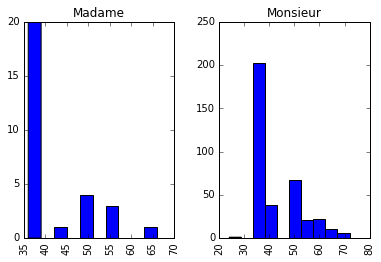

In [437]:
bachelor_data_duration['duration'].hist(by=bachelor_data_duration['sex'])

<b>Selecting a suitable statistical test</b> <br> There are two samples (Male, Female). But the distribution is not normal. The samples are not paired and therefore the 'Mann Whitney' test would be appropriate

In [438]:
x = bachelor_data_duration[bachelor_data_duration['sex']=='Monsieur']['duration']
y = bachelor_data_duration[bachelor_data_duration['sex']=='Madame']['duration']

stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=4690.5, pvalue=0.11499327388541769)

### Conclusion for Bachelor students data:

The null hypothesis is that the mean duration for both male and female students to graduate is not different. The p-value obtained is above the threshold of 0.05 for 95% confidence interval. Thus the null hypothesis cannot be rejected and we can conclude that the difference in duration for male and female students to graduate is not statistically significant. <br>

Further it is to be noted that the number of female students in this analysis is extremely small to draw any reliable conclusions.


## 2. Master students

In [ ]:
UNITE_ACAD = str(section_value[0])   #Informatique value

sem_num = [1, 2, 3, 4, 5, 6, 7, 8] #Maps to [1,2,3,4,Minor1,Minor2,Project Fall,Project Spring]
start_year = range(2007,2017)

master_data = pd.DataFrame()

year_idx=0; sem_idx=0
for year in start_year:                            # Loop through all years
    PERIODE_ACAD = str(year_value[year_idx])       # Value for year
    sem_idx=0
    
    for sem in sem_num:                          # Loop through all semesters
        PERIODE_PEDAGO = str(master_sem_value[sem_idx])   # Value for semester
        
        if (not ((year==2007 and sem>1) or (year==2008 and sem>2) or (year==2016 and sem==1))):
            print(year)
            print(sem)
            ### Form URL using the above extracted values
            url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247' +  \
                    '&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD='+ UNITE_ACAD + '&ww_x_PERIODE_ACAD=' + PERIODE_ACAD + \
                    '&ww_x_PERIODE_PEDAGO=' + PERIODE_PEDAGO + '&ww_x_HIVERETE=null'

            #print(url)
            #"""
            r = requests.get(url)
            soup = BeautifulSoup(r.text,'html.parser')
            #print(soup.prettify())


            sex = [s.text for s in soup.find_all('td')[0::12]]
            #names = [n.text for n in soup.find_all('td')[1::12]]
            #name = [re.sub('\xa0', '', n) for n in names]
            sciper = [s.text for s in soup.find_all('td')[10::12]]
            special = [s.text for s in soup.find_all('td')[4::12]]
            minor = [s.text for s in soup.find_all('td')[6::12]]
            y = [start_year[year_idx]]*len(sciper)
            s = [sem_num[sem_idx]]*len(sciper)
            master_data = master_data.append(pd.DataFrame({'sciper':sciper,'sex':sex,'specail':special,'minor':minor, 'start_year':y,'semester':s}))
        
        sem_idx+=1

    year_idx+=1

The total number of entries in Masters Students data is 2488 (students in 2nd and 3rd semester in 2007 and 2nd semester in 2008 are not included, since 1st semester data is unavailable). <br>

The entries are grouped by 'sciper' and the histogram of the time spent(in months) by all the students is as shown below.

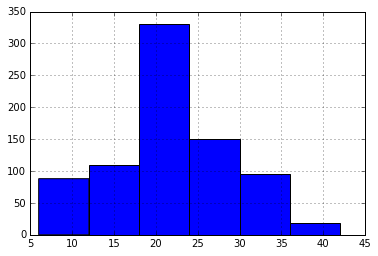

In [279]:
master_data['sciper'].groupby(master_data['sciper']).apply(lambda x: x.count()*6).hist(bins=[6, 12, 18, 24, 30, 36, 42])

The time spent by the students can be computed by grouping the entries by 'sciper' and counting the number of semesters for each student. The average time spent is 18.87 months.

In [418]:
duration_months = pd.DataFrame({'average_stay': master_data['sciper'].groupby(master_data['sciper']).apply(lambda x: x.count()*6)})
average_stay_all = np.mean(master_data_duration['average_stay'])
average_stay_all

18.872313527180783

In [421]:
## Concatenate the duration computed with other data for each student
master_data_unique = master_data.sort_values(['sciper','semester'])[['sciper','sex']].drop_duplicates()
master_data_unique = master_data_unique.set_index('sciper')
master_data_duration = pd.concat([master_data_unique, duration_months], axis=1)
master_data_duration.head()

,sex,average_stay
sciper,,
138088,Monsieur,6
146330,Monsieur,6
146742,Monsieur,42
146929,Monsieur,6
147008,Monsieur,24


Next, only those students who had taken specialisation are selected. There are 231 such students. But 5 of those students had multiple specialisations. These entries are considered as outliers and are removed before further processing. This should not affect the overall results since the number of students with such multiple specialisations is only 5.

In [422]:
## Select only those students with specialisation
master_data_special = master_data[master_data['specail'] != '']
master_data_special = master_data_special.sort_values(['sciper'])[['sciper','sex','specail']].drop_duplicates()

## Remove students with multiple specialisations
master_data_special = master_data_special.groupby('sciper').filter(lambda x: x['sciper'].count()==1)
master_data_special = master_data_special.set_index('sciper')
master_data_special.head()

,sex,specail
sciper,,
146742,Monsieur,"Signals, Images and Interfaces"
147008,Monsieur,"Signals, Images and Interfaces"
153066,Monsieur,Internet computing
154080,Monsieur,Internet computing
154573,Madame,Biocomputing


In [423]:
## Concatenate the duration and list of students with specialisation
master_data_final = pd.concat([master_data_duration, master_data_special], axis=1, join='inner')
master_data_final = master_data_final.rename(columns={"average_stay":"duration","specail":"special"})
master_data_final.head()

,sex,duration,sex,special
sciper,,,,
146742,Monsieur,42,Monsieur,"Signals, Images and Interfaces"
147008,Monsieur,24,Monsieur,"Signals, Images and Interfaces"
153066,Monsieur,24,Monsieur,Internet computing
154080,Monsieur,18,Monsieur,Internet computing
154573,Madame,24,Madame,Biocomputing


The number of students with each specialisation is shown below. It is to be noted that the number of students for few specialisations are very less and therefore it is not possible to draw any conclusions for such specialisations.

In [425]:
master_data_final.groupby('special').apply(lambda x: x['special'].count())

special
Biocomputing                       4
Computer Engineering - SP         19
Computer Science Theory            1
Data Analytics                     5
Foundations of Software           54
Information Security - SP          7
Internet Information Systems       1
Internet computing                84
Service science                    3
Signals, Images and Interfaces    27
Software Systems                  16
dtype: int64

The average time spent (in months) for each specialisation is then computed. The "average_stay" at EPFL for all the students was earlier determined as 18.87. 

In [428]:
master_data_final.groupby('special').apply(lambda x: np.mean(x['duration'])).round(3)

special
Biocomputing                      16.500
Computer Engineering - SP         22.421
Computer Science Theory           18.000
Data Analytics                    14.400
Foundations of Software           23.778
Information Security - SP         21.429
Internet Information Systems      18.000
Internet computing                22.429
Service science                   22.000
Signals, Images and Interfaces    25.333
Software Systems                  21.000
dtype: float64

Finally we can determine if the above results are statistically significant. We have a population (with all the students) and the sample (students with each specialisation). <br> 
Null Hypothesis: The mean time spent by sample (specialisation) and the population (overall) is same. <br>
The samples are normally distributed and thereby one-sample t-test would be appropriate.

In [405]:
count=0
for sp in master_data_final['special'].unique():
    print(sp)
    tmp = master_data_final[master_data_final['special']==sp]
    print(stats.ttest_1samp(a= tmp['duration'], popmean= average_stay_all))
    
    ## Compare histograms of population and sample for each specialisation
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #_ = ax.hist(duration_months['average_stay'].tolist())
    #_ = ax.hist(tmp['duration'].tolist(), color='red', alpha=.3)
    count+=1

Signals, Images and Interfaces
Ttest_1sampResult(statistic=4.3679134130383908, pvalue=0.00017818153176245985)
Internet computing
Ttest_1sampResult(statistic=4.7136229229028261, pvalue=9.6910213002374536e-06)
Biocomputing
Ttest_1sampResult(statistic=-0.62844120557080996, pvalue=0.57430426386649391)
Foundations of Software
Ttest_1sampResult(statistic=5.0195944558059935, pvalue=6.1979277951052156e-06)
Service science
Ttest_1sampResult(statistic=0.78192161820480433, pvalue=0.51613255572659578)
Computer Engineering - SP
Ttest_1sampResult(statistic=2.9568275854438131, pvalue=0.0084407815488575476)
Software Systems
Ttest_1sampResult(statistic=1.9423031274361464, pvalue=0.071118172773421959)
Information Security - SP
Ttest_1sampResult(statistic=1.1550401660813268, pvalue=0.29199198989675895)
Data Analytics
Ttest_1sampResult(statistic=-1.8634639696586595, pvalue=0.13585461989456588)
Internet Information Systems
Ttest_1sampResult(statistic=nan, pvalue=nan)
Computer Science Theory
Ttest_1sampResu

/Users/nesara/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


### Conclusion for Master students data:

Considering a confidence interval of 95%, the p-values for the following specialisations are less than 0.05. <br>
<ul>
<li>Signals, Images and Interfaces </li>
<li>Internet computing</li>
<li>Foundations of Software</li>
<li>Computer Engineering - SP</li> <br>
Based on this, we can reject the null hypothesis for the above specialisations and conclude that the average time spent by students with these specialisations is more than the overall average stay and that these results are statistically significant.